In [1]:
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import numpy as np
import torchvision.transforms as TF
import torch
import torch.nn as nn
import torchvision.models

## Загрузка датасета

In [2]:
class MyDs(Dataset):
    def __init__(self, pos_files, neg_files, tfm=None):
        self.pos_files = pos_files
        self.neg_files = neg_files
        self.tfm = tfm
    def __len__(self): return len(self.pos_files) + len(self.neg_files)
    def __getitem__(self, i):
        if i < len(self.pos_files):
            pf = data_path / 'def_front' / self.pos_files[i]
            lbl = 1
        else:
            pf = data_path / 'ok_front' / self.neg_files[i - len(self.pos_files)]
            lbl = 0
        image = Image.open(pf)
        if self.tfm is not None:
            image = self.tfm(image)
        return image, lbl

In [3]:
data_path = Path('casting_512x512')

pos_files = sorted(os.listdir(data_path / 'def_front'))
neg_files = sorted(os.listdir(data_path / 'ok_front'))

np.random.seed(0)
np.random.shuffle(pos_files)
np.random.shuffle(neg_files)

_N = int(len(pos_files) * 0.8)
trn_pos_files, val_pos_files = pos_files[:_N], pos_files[_N:]
_N = int(len(neg_files) * 0.8)
trn_neg_files, val_neg_files = neg_files[:_N], neg_files[_N:]
_normalize = TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tfm = TF.Compose([TF.Resize((256,256)), TF.ToTensor(), _normalize])

trn_ds = MyDs(trn_pos_files, trn_neg_files, tfm=tfm)
val_ds = MyDs(val_pos_files, val_neg_files, tfm=tfm)

### Загрузка модели

In [4]:
device = torch.device('cuda:0')
model = torch.load('trained_model.pt').to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Adversarial атака

In [5]:
def fgsm_attack(model, loss, images, labels, eps, device):
    
    images = images
    labels = labels
    images.requires_grad = True
    
    outputs = model.forward(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

### Тестирование

In [7]:
from eXNN.NetBayesianization.api import BasicBayesianWrapper
wrapper_model = BasicBayesianWrapper(model, "beta", p = None, a = 0.6, b = 12.0)

simple_res = {"acc": [], "uncert": []}
corrupted_res = {"acc": [], "uncert": []}

example_normal = None
example_error = None
max_std = 0

for i, img_data in enumerate(val_ds):
    img, cls = img_data[0].cuda().unsqueeze(0), img_data[1]
    pred = wrapper_model.predict(img, n_iter = 10)
    simple_res["acc"].append(pred["mean"].cpu().detach().argmax().item() == cls)
    simple_res["uncert"].append(pred["std"].cpu().detach().numpy())
    
    corrupted_img = fgsm_attack(model, nn.NLLLoss(), img, 
                        torch.LongTensor([cls]).cuda(), eps=0.01, device=device)
    corrupted_pred = wrapper_model.predict(corrupted_img, n_iter = 10)
    corrupted_res["acc"].append(corrupted_pred["mean"].cpu().detach().argmax().item() == cls)
    corrupted_res["uncert"].append(corrupted_pred["std"].cpu().detach().numpy())
    
    if corrupted_pred["mean"].cpu().detach().argmax().item() != pred["mean"].cpu().detach().argmax().item():
        if corrupted_pred["std"].cpu().detach().mean().item() > max_std:
            max_std = corrupted_pred["std"].cpu().detach().mean().item()
            example_error = [img.cpu().detach(), corrupted_img.cpu().detach(), 
                              {i: j.cpu().detach() for i, j in pred.items()},
                              {i: j.cpu().detach() for i, j in corrupted_pred.items()}]
    else:
        example_normal = [img.cpu().detach(), corrupted_img.cpu().detach(), 
                          {i: j.cpu().detach() for i, j in pred.items()},
                          {i: j.cpu().detach() for i, j in corrupted_pred.items()}]
    if i > 100:
        break

### Результаты

([<matplotlib.axis.XTick at 0x25ec54913c8>,
 <a list of 2 Text xticklabel objects>)

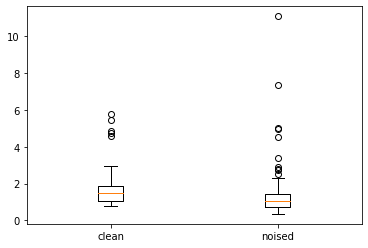

In [8]:
import matplotlib.pyplot as plt

simple_data = np.array([np.mean(i) for i in simple_res["uncert"]])
corrupted_data = np.array([np.mean(i) for i in corrupted_res["uncert"]])

plt.boxplot([simple_data[simple_data < np.percentile(simple_data, 98)],
             corrupted_data[corrupted_data < np.percentile(corrupted_data, 98)]])
plt.xticks([1, 2], ["clean", "noised"])

In [ ]:
def viz_preproc(img):
    img = (img - img.min())/(img.max() - img.min() + 1e-8)
    img = img.cpu().detach().numpy()
    img = np.moveaxis(img, 0, -1)
    return img

fig, ax = plt.subplots(1, 2)
ax[0].imshow(viz_preproc(example_error[0].squeeze()))

pred = example_error[2]
mean, std = pred["mean"].argmax().tolist(), [round(i, 2) for i in pred["std"].squeeze().cpu().detach().tolist()]
ax[0].set_title("Pred {} | Std {}".format(mean, std))

ax[1].imshow(viz_preproc(example_error[1].squeeze()))

corrupted_pred = example_error[3]
mean, std = corrupted_pred["mean"].argmax().tolist(), [round(i, 2) for i in corrupted_pred["std"].squeeze().cpu().detach().tolist()]
ax[1].set_title("Pred {} | Std {}".format(mean, std))